In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

data= pd.read_csv('/Users/theobeevers/AppliedMachineLearning2024/final poject/all_data/train_full.csv')

data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['weekday'] = data['datetime'].dt.weekday
data['hour'] = data['datetime'].dt.hour
data.sort_values(by='datetime', inplace=True)

In [2]:
hold = data[['target', 'installed_capacity']].copy()

data['target'] = data['target']/data['installed_capacity']

data.drop(['installed_capacity'], axis=1, inplace=True)

one_company_data = data[data['prediction_unit_id'] == 0]

production_data = one_company_data[one_company_data['is_consumption'] == 0]

hold = hold[hold.index.isin(production_data.index)]


In [3]:


# one_company_data = data[data['prediction_unit_id'] == 0]

# production_data = one_company_data[one_company_data['is_consumption'] == 0]

# hold = production_data[['target', 'installed_capacity']].copy()

# production_data['target'] = production_data['target']/production_data['installed_capacity']
# production_data.drop(['installed_capacity'], axis=1, inplace=True)

# print(production_data.columns)


In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = ['county', 'product_type', 'hour', 'month', 'weekday', 'day', 'is_business']
numerical_features = production_data.columns.difference(categorical_features + ['target','datetime'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

data_preprocessed = preprocessor.fit_transform(production_data)

In [5]:
def create_sequences(X, y, sequence_length=24):
    X_seqs, y_seqs = [], []
    # Ensure the loop does not go beyond the point where a valid target exists
    for i in range(len(X) - sequence_length):
        X_seqs.append(X[i:i + sequence_length])
        y_seqs.append(y[i + sequence_length])
    return np.array(X_seqs), np.array(y_seqs)

In [6]:
data_features = data_preprocessed 
data_targets = production_data['target'].values 

dates = production_data['datetime'].values 

split_idx = int(len(dates) * 0.5)

# Split the data into training and testing sets
X_train = data_features[:split_idx]
y_train = data_targets[:split_idx]
X_test = data_features[split_idx:]
y_test = data_targets[split_idx:]

# Create sequences for training and testing sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)

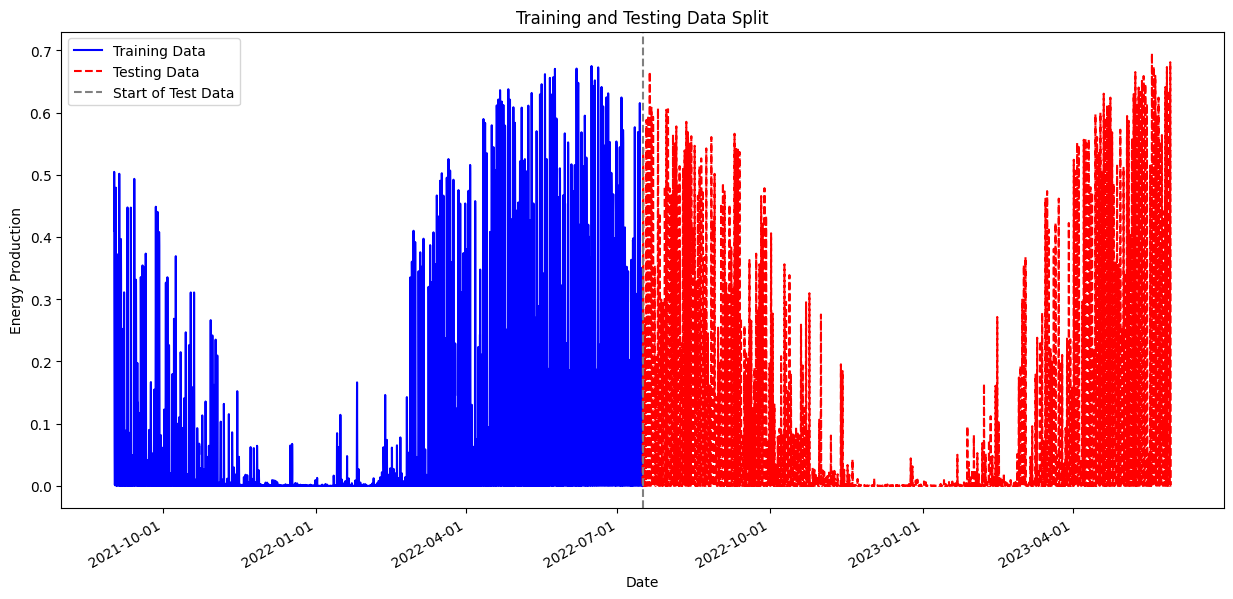

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 7))
plt.plot(dates[:split_idx], y_train, label='Training Data', color='blue')
plt.plot(dates[split_idx:], y_test, label='Testing Data', color='red', linestyle='--')

# Highlight the transition from training to testing
plt.axvline(x=dates[split_idx], color='gray', linestyle='--', label='Start of Test Data')

# Formatting the date on the x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotation

plt.title('Training and Testing Data Split')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.show()

In [8]:
y_train_seq = y_train_seq.reshape(-1, 1)  
y_test_seq = y_test_seq.reshape(-1,1)

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

In [9]:
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, input_dim):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_dim, 50, 2, batch_first=True)  # 50 hidden units, 2 layers
        self.fc = nn.Linear(50, 1)  # Predicting one output per time step


    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x)
        x = x[:, -1, :]
        # Select only the last timestep for each sequence
        return x.unsqueeze(-1)

input_dim = X_train_tensor.shape[2]  # This is the number of features per time step


In [10]:
import torch.optim as optim

model = GRUNet(input_dim)  # Ensure the input_dim is correctly set
criterion = nn.L1Loss()  # L1 Loss function for MAE
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 1, Training Loss: 0.1814212203025818
Epoch 1, Validation Loss: 0.1209423765540123
Epoch 2, Training Loss: 0.12722302973270416
Epoch 2, Validation Loss: 0.09838158637285233
Epoch 3, Training Loss: 0.0954466238617897
Epoch 3, Validation Loss: 0.10569383203983307
Epoch 4, Training Loss: 0.08334437757730484
Epoch 4, Validation Loss: 0.11633721739053726
Epoch 5, Training Loss: 0.08337496966123581
Epoch 5, Validation Loss: 0.11911998689174652
Epoch 6, Training Loss: 0.08200127631425858
Epoch 6, Validation Loss: 0.11470860987901688
Epoch 7, Training Loss: 0.0779535099864006
Epoch 7, Validation Loss: 0.10553638637065887
Epoch 8, Training Loss: 0.07281522452831268
Epoch 8, Validation Loss: 0.09409555047750473
Epoch 9, Training Loss: 0.06780917942523956
Epoch 9, Validation Loss: 0.08236852288246155
Epoch 10, Training Loss: 0.0635240226984024
Epoch 10, Validation Loss: 0.07224135845899582
Epoch 11, Training Loss: 0.06021907925605774
Epoch 11, Validation Loss: 0.06481198221445084
Epoch 12, T

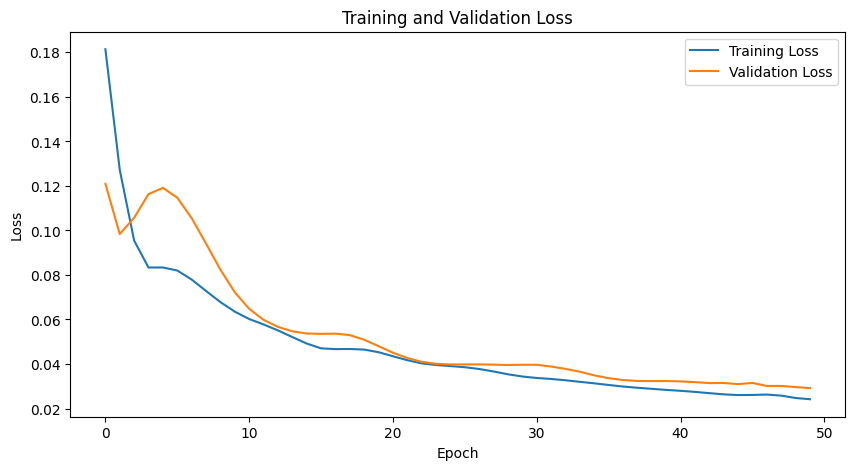

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Make sure your data tensors are also moved to the same device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# Cast tensors to float16
# Ensure everything is in float16
# model = model.half()  # Convert model to float16
# X_train_tensor = X_train_tensor.half()
# y_train_tensor = y_train_tensor.half()
# X_val_tensor = X_val_tensor.half()
# y_val_tensor = y_val_tensor.half()

num_epochs = 50 # Define the number of epochs
# print("Check NaN or Inf in inputs:", torch.isnan(X_train_tensor).any(), torch.isinf(X_train_tensor).any())
# print("Check NaN or Inf in targets:", torch.isnan(y_train_tensor).any(), torch.isinf(y_train_tensor).any())

# print("Check NaN or Inf in inputs:", torch.isnan(X_val_tensor).any(), torch.isinf(X_val_tensor).any())
# print("Check NaN or Inf in targets:", torch.isnan(y_val_tensor).any(, torch.isinf(y_val_tensor).any())


# Check for NaNs in each feature
# nan_counts = pd.DataFrame(torch.isnan(X_train_tensor).sum(dim=0))
# print("NaN counts per feature:", nan_counts)
# nan_counts.to_csv('nan_counts')

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    outputs = outputs.squeeze(-1)

    loss = criterion(outputs, y_train_tensor)
    if not torch.isfinite(loss):
        print(f"Stopping training, loss has become {loss.item()}")
        break  # Early exit if loss is nan or inf
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    print(f'Epoch {epoch+1}, Training Loss: {loss.item()}')

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_outputs = val_outputs.squeeze(-1)  # Ensure validation output matches target shape
        val_loss = criterion(val_outputs, y_val_tensor)
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss.item()}')

    # Existing training and validation code...
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())


plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
model.eval()

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)  # Ensure data is on the correct device
    predicted_output = model(X_test_tensor)
    predicted_output = predicted_output.cpu().numpy().flatten()  # Move predictions back to CPU and flatten if necessary

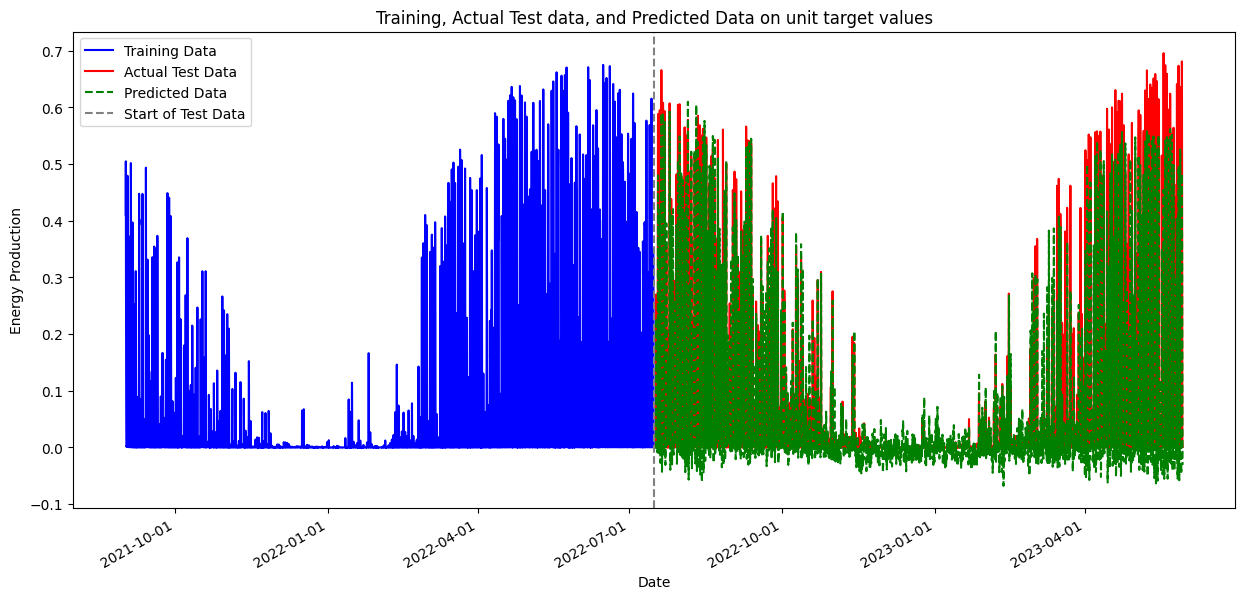

In [23]:

dates = production_data['datetime'].values  # Ensure correct format
sequence_length = 24 

split_idx = int(len(dates) * 0.5)
# Prediction starts after the first 'sequence_length' entries in the test set
prediction_start_idx = split_idx + sequence_length

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(dates[:split_idx], y_train, label='Training Data', color='blue')
plt.plot(dates[prediction_start_idx:], y_val_tensor.flatten(), label='Actual Test Data', color='red')
plt.plot(dates[prediction_start_idx:], predicted_output, label='Predicted Data', color='green', linestyle='--')

plt.axvline(x=dates[split_idx], color='gray', linestyle='--', label='Start of Test Data')

# Formatting the date on the x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotation

plt.title('Training, Actual Test data, and Predicted Data on unit target values')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.show()

In [14]:
mae = mean_absolute_error(y_val_tensor.flatten(), predicted_output)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.029191654175519943


Text(0, 0.5, 'Predictions')

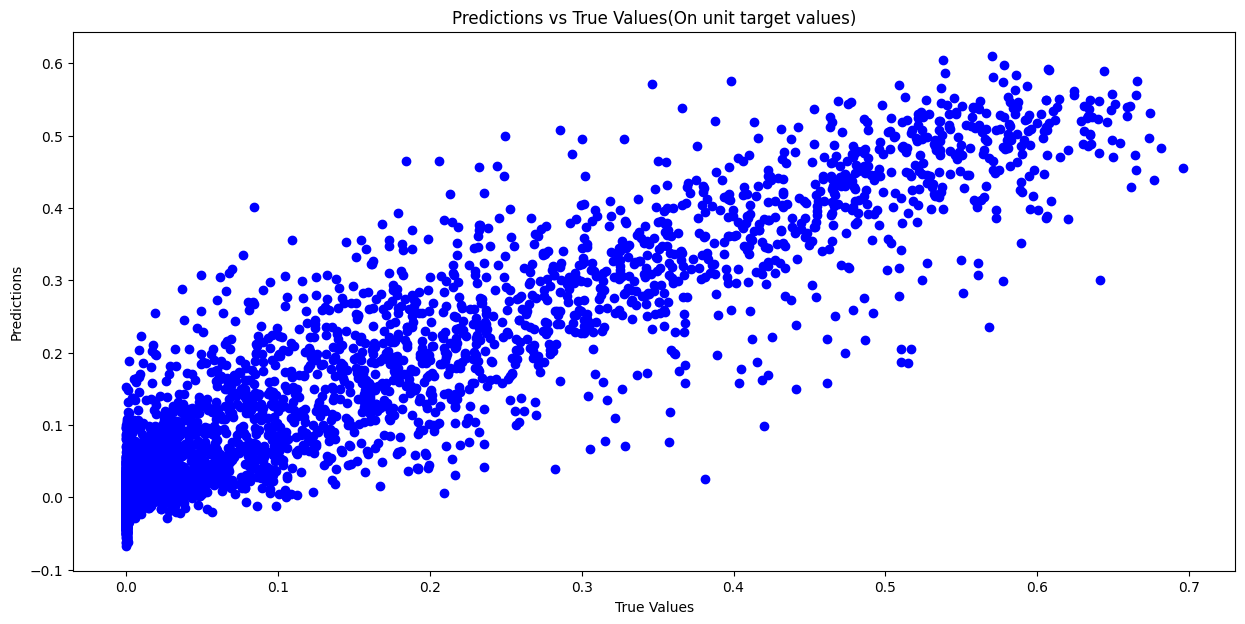

In [31]:
plt.figure(figsize=(15, 7))
plt.scatter(y_val_tensor.flatten(),predicted_output, c='blue', label='Predictions')
plt.title('Predictions vs True Values(On unit target values)')
plt.xlabel('True Values')
plt.ylabel('Predictions')


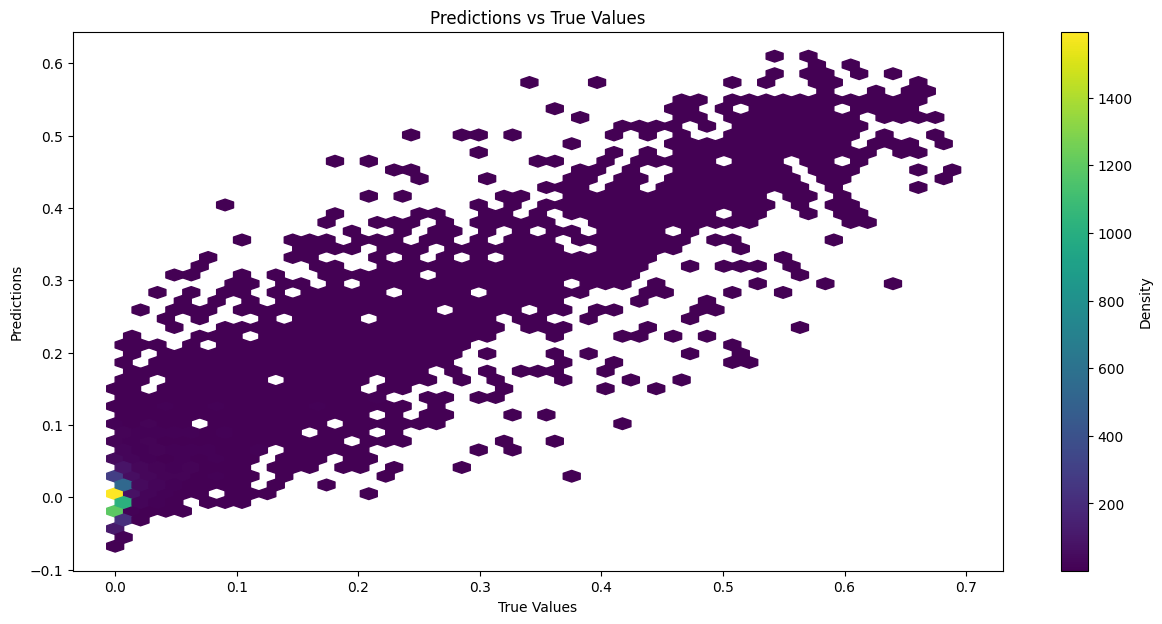

In [30]:
import matplotlib.pyplot as barplot
import numpy as np

# Assuming y_val_tensor.flatten() and predicted_output are your arrays for plotting
x = y_val_tensor.flatten()
y = predicted_output

# Set up the figure size
barplot.figure(figsize=(15, 7))

# Create a hexbin plot with a colorbar using the 'viridis' colormap
hb = barplot.hexbin(x, y, gridsize=50, cmap='viridis', mincnt=1)  # 'mincnt=1' ignores bins with zero counts
cb = barplot.colorbar(hb)  # Add a colorbar
cb.set_label('Density')

# Set titles and labels
barplot.title('Predictions vs True Values')
barplot.xlabel('True Values')
barplot.ylabel('Predictions')

# Show the plot
barplot.show()



In [24]:
from sklearn.metrics import r2_score
r2 = r2_score(y_val_tensor.flatten(), predicted_output)
print(f'R2 Score: {r2}')

R2 Score: 0.8814941419338398


In [15]:
mae_array = np.array([])
mae_array = np.append(mae_array, mae)


In [16]:
print(mae_array)

[0.02919165]


In [36]:
original_data = hold['target'][prediction_start_idx:]
scaled_predictions = predicted_output * hold[prediction_start_idx:]['installed_capacity']

print(np.shape(original_data))
print(np.shape(scaled_predictions))
print(np.shape(hold[prediction_start_idx:]['installed_capacity']))
print(hold)

mae_original = mean_absolute_error(original_data[:3000])

(7600,)
(7600,)
(7600,)
          target  installed_capacity
0        391.054             952.890
120      480.938             952.890
240      422.591             952.890
360      303.120             952.890
480      208.335             952.890
...          ...                 ...
1978842  328.973            4964.215
1978970   74.772            4964.215
1979098   11.246            4964.215
1979226    2.787            4964.215
1979354    3.215            4964.215

[15247 rows x 2 columns]


In [37]:
print(f'Mean Absolute Error on original scale: {mae_original}')

Mean Absolute Error on original scale: 120.92965143211588


In [25]:
from sklearn.metrics import r2_score

r2_original = r2_score(original_data, scaled_predictions)
print(f'R2 Score (rescaled): {r2_original}')

R2 Score (rescaled): 0.878696310624211


Text(0, 0.5, 'Predictions')

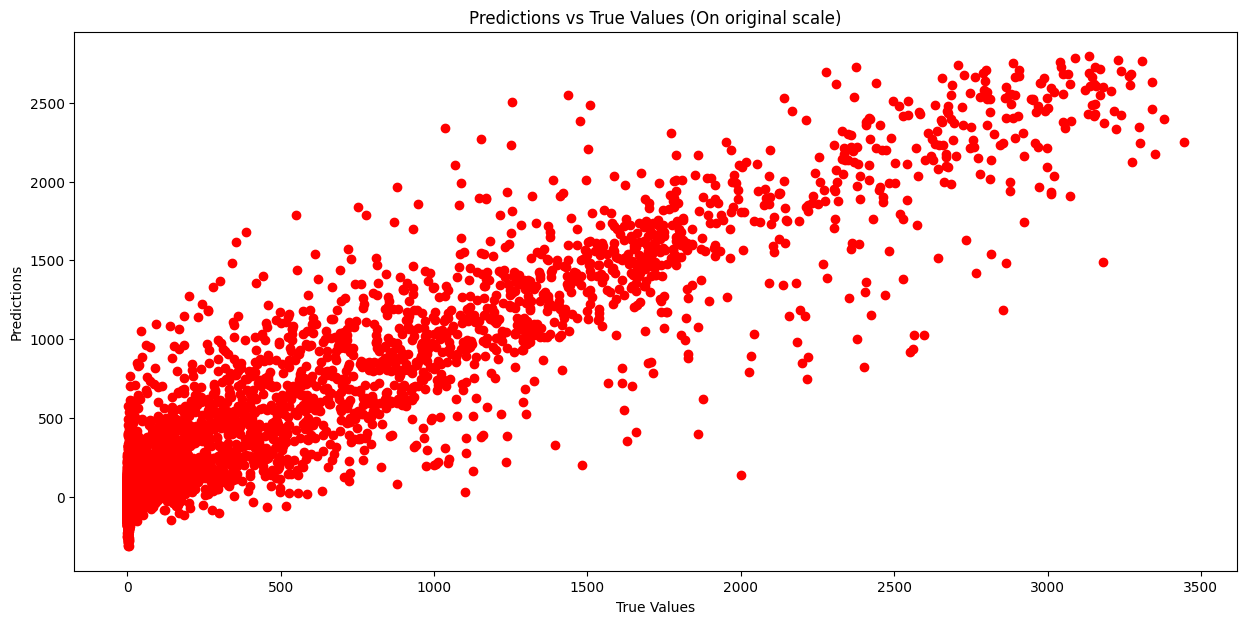

In [33]:
plt.figure(figsize=(15, 7))
plt.scatter(original_data,scaled_predictions, c='red', label='Predictions')
plt.title('Predictions vs True Values (On original scale)')
plt.xlabel('True Values')
plt.ylabel('Predictions')

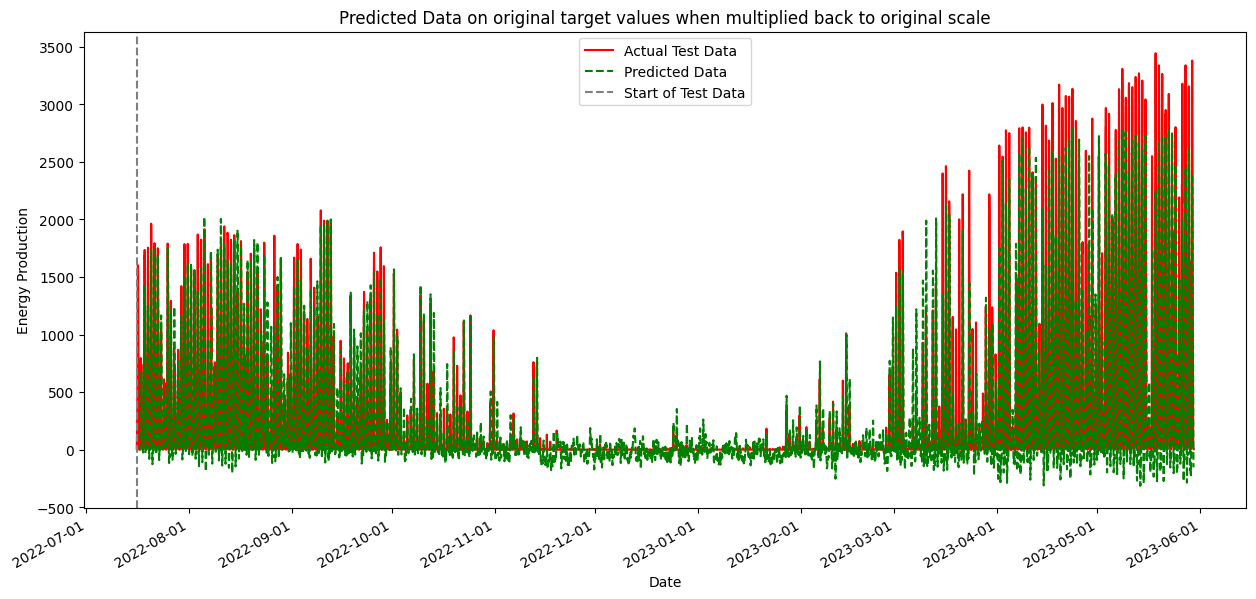

In [19]:
original = hold['installed_capacity'][prediction_start_idx:] * predicted_output

plt.figure(figsize=(15, 7))
plt.plot(dates[split_idx:], hold['target'][split_idx:], label='Actual Test Data', color='red')
plt.plot(dates[prediction_start_idx:], original, label='Predicted Data', color='green', linestyle='--')
plt.axvline(x=dates[split_idx], color='gray', linestyle='--', label='Start of Test Data')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.title('Predicted Data on original target values when multiplied back to original scale')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.show()

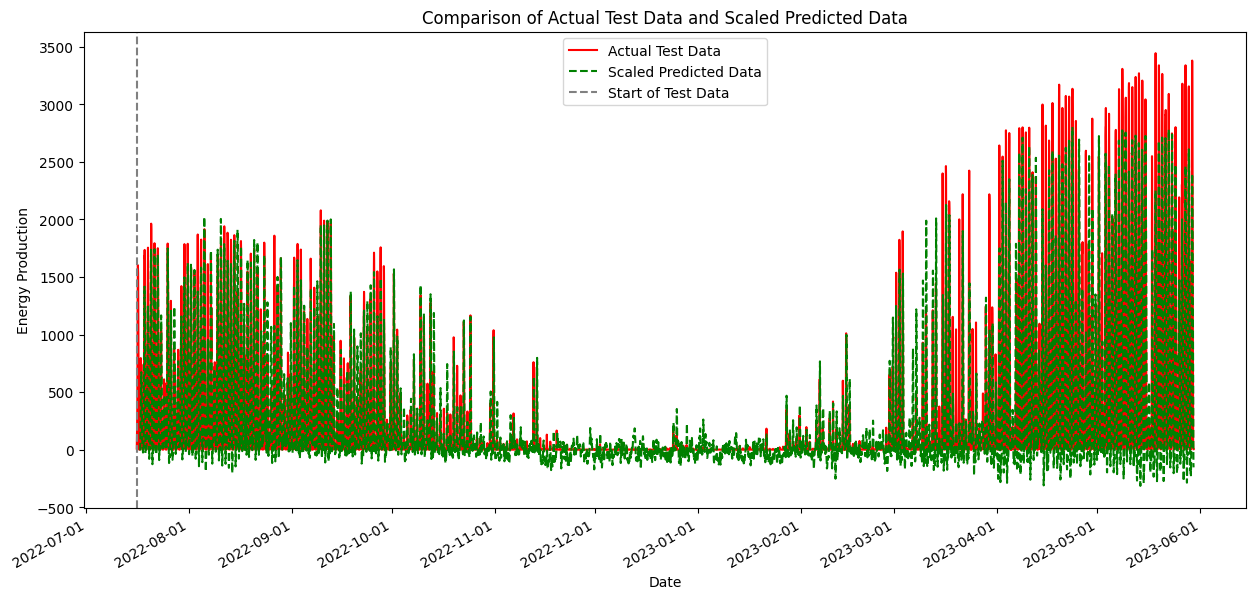

In [20]:

scaled_predictions = hold['installed_capacity'][prediction_start_idx:] * predicted_output

plt.figure(figsize=(15, 7))
plt.plot(dates[split_idx:], hold['target'][split_idx:], label='Actual Test Data', color='red')
plt.plot(dates[prediction_start_idx:], scaled_predictions, label='Scaled Predicted Data', color='green', linestyle='--')

plt.axvline(x=dates[split_idx], color='gray', linestyle='--', label='Start of Test Data')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.title('Comparison of Actual Test Data and Scaled Predicted Data')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.show()

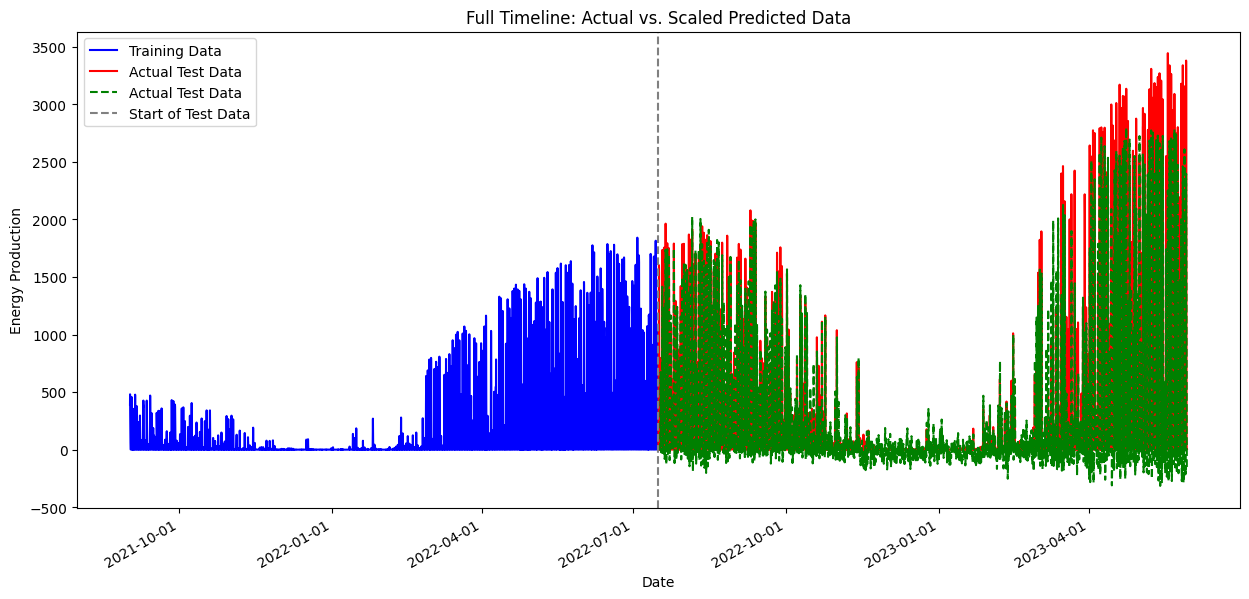

In [21]:
full_scaled_predictions = np.empty_like(hold['target'])
full_scaled_predictions[:] = np.nan  # Initialize with NaNs
full_scaled_predictions[prediction_start_idx:] = hold['installed_capacity'][prediction_start_idx:] * predicted_output

plt.figure(figsize=(15, 7))
plt.plot(dates[:split_idx], hold['target'][:split_idx], label='Training Data', color='blue')
plt.plot(dates[split_idx:], hold['target'][split_idx:], label='Actual Test Data', color='red')
plt.plot(dates[prediction_start_idx:], scaled_predictions, label='Actual Test Data', color='green', linestyle='--')

plt.axvline(x=dates[split_idx], color='gray', linestyle='--', label='Start of Test Data')

# Format the date on the x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.title('Full Timeline: Actual vs. Scaled Predicted Data')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.show()

In [22]:
actual_test_values = hold['target'][prediction_start_idx:]

mae = mean_absolute_error(actual_test_values, scaled_predictions)
print(f"Mean Absolute Error for scaled predictions: {mae}")


Mean Absolute Error for scaled predictions: 123.15589977925664


ValueError: Found input variables with inconsistent numbers of samples: [7624, 7600]